In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


import punch_party_utils

In [2]:
air_quality_df = punch_party_utils.make_average_aq_df()
average_air_quality = air_quality_df[air_quality_df["MeasureName"] == "Annual average ambient concentrations of PM2.5 in micrograms per cubic meter (based on seasonal averages and daily measurement)"]


# For the first model, just CO2 emmisions in a given year -> air quality in a given year
air_quality_df = air_quality_df.drop(
    columns=["MeasureId", "MeasureName", "MeasureType", "StratificationLevel",
             "StateFips", "StateName", "CountyFips", "Unit",
             "UnitName", "DataOrigin", "MonitorOnly"])

# air_quality_df = air_quality_df.drop("CountyName")

In [3]:
air_quality_df["County_Year"] = air_quality_df["CountyName"] + "_" + air_quality_df["ReportYear"].astype(str)

In [4]:
print(len(air_quality_df))

aq_year_only = air_quality_df.drop(columns=["CountyName", "County_Year"])
display(aq_year_only.columns)
aq_by_year = aq_year_only.groupby("ReportYear")

print ("\n")

air_quality_yearly_averages = aq_by_year.agg("mean")
print(air_quality_yearly_averages)

42621


Index(['ReportYear', 'Value'], dtype='object')



                Value
ReportYear           
1999        13.748994
2000        13.020075
2001        11.958253
2002        11.235081
2003        11.194532
2004        10.966340
2005        11.737703
2006        10.923896
2007        11.301560
2008        10.335900
2009         9.430018
2010         9.596560
2011         9.372181
2012         9.063382
2013         8.821925


In [5]:
gas_types = punch_party_utils.make_gas_types_df()

gas_types = gas_types.drop(
    columns=["Address Line 1", "City", 
             "Facility ID", "Gas Code", "Latitude", "Longitude", 
             "State Name", "Zip Code", "Facility Name"])

gas_types["County_Year"] = gas_types["County"] + "_" + gas_types["Year"].astype(str)

display(gas_types.head())

,CO2 Emission,County,Gas Name,Year,County_Year
0,58024.000,BROWN,BIOGENIC CO2,2017,BROWN_2017
1,134.500,NEW,METHANE,2018,NEW_2018
2,6.854,SABINE,NITROUS OXIDE,2012,SABINE_2012
3,53562.000,WASHINGTON,METHANE,2017,WASHINGTON_2017
4,7635064.700,TRIMBLE,CARBON DIOXIDE,2018,TRIMBLE_2018


In [6]:
raw_emmisions_year_only = gas_types.drop(columns=["Gas Name", "County", "County_Year"])
yearly_raw_emmisions = raw_emmisions_year_only.groupby("Year").agg("sum")
print(yearly_raw_emmisions)

      CO2 Emission
Year              
2010  3.229325e+09
2011  3.333042e+09
2012  3.194602e+09
2013  3.210963e+09
2014  3.222917e+09
2015  3.078839e+09
2016  3.019157e+09
2017  2.947673e+09
2018  3.037238e+09
2019  2.898178e+09


<class 'pandas.core.frame.DataFrame'>


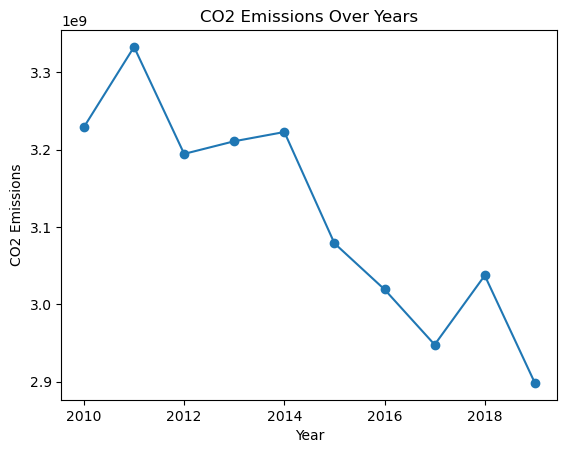

In [27]:
print(type(yearly_raw_emmisions))

plt.plot(yearly_raw_emmisions.index, yearly_raw_emmisions['CO2 Emission'], marker='o')
plt.title('CO2 Emissions Over Years')
plt.xlabel('Year')
plt.ylabel('CO2 Emissions')
plt.savefig('CO2_emmisions_by_year.png')
plt.show()

In [7]:
co2_emmisions_with_aq = yearly_raw_emmisions.merge(
    air_quality_yearly_averages, left_index=True, right_index=True, how="inner")
print(co2_emmisions_with_aq)

      CO2 Emission     Value
2010  3.229325e+09  9.596560
2011  3.333042e+09  9.372181
2012  3.194602e+09  9.063382
2013  3.210963e+09  8.821925


In [8]:
# Normalize
max_co2_emission = np.max(co2_emmisions_with_aq["CO2 Emission"])
max_co2_emission
co2_emmisions_with_aq["CO2 Emission"] = co2_emmisions_with_aq["CO2 Emission"] / max_co2_emission

display(co2_emmisions_with_aq)

,CO2 Emission,Value
2010,0.968882,9.596560
2011,1.000000,9.372181
2012,0.958464,9.063382
2013,0.963373,8.821925


In [9]:
co2_aq_model = LinearRegression(fit_intercept=True)

independent_var = co2_emmisions_with_aq[["CO2 Emission"]]
dependent_var = co2_emmisions_with_aq["Value"]

display(independent_var)
display(dependent_var)

co2_aq_model.fit(independent_var, dependent_var)

,CO2 Emission
2010,0.968882
2011,1.000000
2012,0.958464
2013,0.963373


2010    9.596560
2011    9.372181
2012    9.063382
2013    8.821925
Name: Value, dtype: float64

LinearRegression()

In [10]:
# Divide value to predict by max emission from training for normalization consistency
value_to_predict = (3.2 * 10**9) / max_co2_emission

print(co2_aq_model.predict(np.array([value_to_predict]).reshape(-1, 1)))

[9.10959159]


/home/sean/miniconda3/envs/msse-python/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [11]:
emissions_per_year_per_gas = gas_types.drop(columns=["County", "County_Year"]).groupby(['Year', 'Gas Name']).mean()

emissions_per_year_per_gas = emissions_per_year_per_gas.reset_index()

emissions_per_year_per_gas = emissions_per_year_per_gas.pivot(index='Year', columns='Gas Name', values='CO2 Emission').dropna()

display(emissions_per_year_per_gas.head())

Gas Name,BIOGENIC CO2,CARBON DIOXIDE,HFCS,HFES,METHANE,NITROGEN TRIFLOURIDE,NITROUS OXIDE,OTHER,OTHER FULLY FLUORINATED GHGS,PFCS,SULFUR HEXAFLUORIDE,VERY SHORT-LIVED COMPOUNDS
Year,,,,,,,,,,,,
2011,219854.886983,462302.634066,196118.872666,888.608834,31507.831677,22648.793747,6002.174766,6747.611722,28001.296085,113693.707661,34794.461450,7.803089
2012,221692.959997,428138.510385,153791.590090,680.194925,29956.920238,20703.412830,4755.363164,6425.133333,28315.847044,104668.101817,28516.478182,5.895594
2013,215409.963821,427731.424518,129820.451666,623.485861,29092.144228,16215.268148,4291.312665,5294.825375,32481.755893,103245.245113,27478.328136,8.221518
2014,211993.601611,420014.630570,121274.558525,1409.273671,28052.491027,15063.658824,4523.518900,4466.333333,27371.955091,93473.825614,27592.388072,13.654441
2015,214321.305711,405575.849913,100378.183108,4111.709119,28259.379143,16324.279200,4282.749662,4692.033333,25813.783808,87343.614173,24874.326846,10.037224


In [12]:
all_gasses_with_air_quality = emissions_per_year_per_gas.merge(
    air_quality_yearly_averages, left_index=True, right_index=True, how="inner")
display(all_gasses_with_air_quality) 

,BIOGENIC CO2,CARBON DIOXIDE,HFCS,HFES,METHANE,NITROGEN TRIFLOURIDE,NITROUS OXIDE,OTHER,OTHER FULLY FLUORINATED GHGS,PFCS,SULFUR HEXAFLUORIDE,VERY SHORT-LIVED COMPOUNDS,Value
2011,219854.886983,462302.634066,196118.872666,888.608834,31507.831677,22648.793747,6002.174766,6747.611722,28001.296085,113693.707661,34794.461450,7.803089,9.372181
2012,221692.959997,428138.510385,153791.590090,680.194925,29956.920238,20703.412830,4755.363164,6425.133333,28315.847044,104668.101817,28516.478182,5.895594,9.063382
2013,215409.963821,427731.424518,129820.451666,623.485861,29092.144228,16215.268148,4291.312665,5294.825375,32481.755893,103245.245113,27478.328136,8.221518,8.821925


In [13]:
def model_air_quality_from_multiple_gasses(gasses, aq_values):
    """ArithmeticError
    parameters
    ----------
    df : Dataframe
        A dataframe with an independent variable for each gas type we wish to use as a feature for air quality prediction.
    aq_values : Series
        A series representing the dependent variable to train on.

    returns
    -------
    A model that can predict air quality from a given input of gas types

    """
    model_with_gas_types = LinearRegression(fit_intercept=True)
    assert len(gasses) == len(aq_values), "Length of input dataframe does not equal length of output dataframe"

    model_with_gas_types.fit(gasses, aq_values)

    print("Intercept of the model:")
    print(model_with_gas_types.intercept_)
    print("\n")
    print("Features of the model:")
    print(gasses.columns.tolist())
    print("\n")
    print("Coefficients of the model:")
    print(model_with_gas_types.coef_)

    return model_with_gas_types

In [14]:
all_gasses_per_year = all_gasses_with_air_quality.drop(columns=["Value"])
air_qualities_by_year = all_gasses_with_air_quality["Value"]
max_gas_emissions_per_year = all_gasses_per_year.max()
normalized_max_gas_emissions = all_gasses_per_year / max_gas_emissions_per_year
air_qualities_by_year = all_gasses_with_air_quality["Value"]

model_with_gas_types = model_air_quality_from_multiple_gasses(normalized_max_gas_emissions, air_qualities_by_year)

Intercept of the model:
7.520742140483977


Features of the model:
['BIOGENIC CO2', 'CARBON DIOXIDE', 'HFCS', 'HFES', 'METHANE', 'NITROGEN TRIFLOURIDE', 'NITROUS OXIDE', 'OTHER', 'OTHER FULLY FLUORINATED GHGS', 'PFCS', 'SULFUR HEXAFLUORIDE', 'VERY SHORT-LIVED COMPOUNDS']


Coefficients of the model:
[-1.12278356 -0.05521366 -0.80792737  2.27842992  1.35020234  0.68148472
 -0.08529045  0.05376891 -0.0440125   0.77360609 -0.96595478 -0.23206163]


In [15]:
example_value_to_predict = np.array([215409.963821, 427731.424518, 129820.451666, 623.485861, 29092.144228, 16215.268148, 4291.312665, 5294.825375, 32481.755893, 103245.245113, 27478.328136, 8.221518]).reshape(-1, 1)
max_gas_emissions = all_gasses_with_air_quality.drop(columns=["Value"]).max()
normalized_values_to_predict = example_value_to_predict / np.array(max_gas_emissions).reshape(-1, 1)
normalized_values_to_predict = normalized_values_to_predict.T

prediction = model_with_gas_types.predict(normalized_values_to_predict)
print(prediction)

[8.82192485]


/home/sean/miniconda3/envs/msse-python/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [16]:
aq_county_year = air_quality_df.drop(columns=["CountyName", "ReportYear"])
display(aq_county_year.columns)
aq_county_year = aq_county_year.groupby("County_Year")

print ("\n")

air_quality_county_yearly_averages = aq_county_year.agg("mean")
print(air_quality_county_yearly_averages)

Index(['Value', 'County_Year'], dtype='object')



                    Value
County_Year              
ABBEVILLE_2001  14.211375
ABBEVILLE_2002  13.130120
ABBEVILLE_2003  13.184619
ABBEVILLE_2004  13.725566
ABBEVILLE_2005  14.178854
...                   ...
ZIEBACH_2007     6.366442
ZIEBACH_2008     6.497561
ZIEBACH_2009     6.901008
ZIEBACH_2010     6.692292
ZIEBACH_2011     6.230142

[21562 rows x 1 columns]


In [17]:
print(gas_types)
raw_emmisions_county_year = gas_types.drop(columns=["Gas Name", "County", "Year"])
county_yearly_raw_emmisions = raw_emmisions_county_year.groupby("County_Year").agg("sum")
print(county_yearly_raw_emmisions)

        CO2 Emission      County        Gas Name  Year      County_Year
0          58024.000       BROWN    BIOGENIC CO2  2017       BROWN_2017
1            134.500         NEW         METHANE  2018         NEW_2018
2              6.854      SABINE   NITROUS OXIDE  2012      SABINE_2012
3          53562.000  WASHINGTON         METHANE  2017  WASHINGTON_2017
4        7635064.700     TRIMBLE  CARBON DIOXIDE  2018     TRIMBLE_2018
...              ...         ...             ...   ...              ...
219922    301493.000      SKAGIT    BIOGENIC CO2  2016      SKAGIT_2016
219923      1929.800      SKAGIT  CARBON DIOXIDE  2016      SKAGIT_2016
219924      2776.500    GUILFORD  CARBON DIOXIDE  2018    GUILFORD_2018
219926        23.840    BRADFORD   NITROUS OXIDE  2012    BRADFORD_2012
219927        23.000    BRADFORD         METHANE  2013    BRADFORD_2013

[203601 rows x 5 columns]
             CO2 Emission
County_Year              
ACADIA_2010   1448577.425
ACADIA_2011   1572541.979
ACADI

In [18]:
county_year_only = gas_types.drop(columns=["Year", "County"])

In [19]:
emissions_per_county_year_per_gas = county_year_only.groupby(['County_Year', 'Gas Name']).mean()

emissions_per_county_year_per_gas = emissions_per_county_year_per_gas.reset_index()

emissions_per_county_year_per_gas = emissions_per_county_year_per_gas.pivot(index='County_Year', columns='Gas Name', values='CO2 Emission')

# Counting NaNs per column
# nan_count = emissions_per_county_year_per_gas.isna().sum()

# print(nan_count)

# The following gasses have NaN in over 10000 of the ~12000 rows of the emissions_per_county_year_per_gas dataframe, dropping these columns before modelling.
gasses_with_insufficient_measurements = ["HFCS", "HFES", "NITROGEN TRIFLOURIDE", "OTHER", "OTHER FULLY FLUORINATED GHGS", "PFCS", "SULFUR HEXAFLUORIDE", "VERY SHORT-LIVED COMPOUNDS"]

display(len(emissions_per_county_year_per_gas))
emissions_per_county_year_per_gas = emissions_per_county_year_per_gas.drop(columns=gasses_with_insufficient_measurements).dropna()
display(len(emissions_per_county_year_per_gas))

display(emissions_per_county_year_per_gas.head())

11730

4156

Gas Name,BIOGENIC CO2,CARBON DIOXIDE,METHANE,NITROUS OXIDE
County_Year,,,,
ADAMS_2015,338.5,9.461366e+05,13728.293478,5257.448444
ADAMS_2016,26.6,1.064286e+06,13979.718750,5353.520333
ADAMS_2018,11.9,5.177267e+05,13150.250000,1727.270737
ADAMS_2019,11.9,4.123245e+05,13830.102273,893.368941
ADA_2015,12206.1,1.331350e+04,56095.500000,85.675000


In [20]:
gasses_with_air_quality_and_counties = emissions_per_county_year_per_gas.merge(
    air_quality_county_yearly_averages, left_index=True, right_index=True, how="inner")
display(gasses_with_air_quality_and_counties) 
display(len(gasses_with_air_quality_and_counties)) 

,BIOGENIC CO2,CARBON DIOXIDE,METHANE,NITROUS OXIDE,Value
County_Year,,,,,
AIKEN_2010,16171.000000,444627.100000,18422.875000,1329.974000,12.340038
AIKEN_2011,10549.000000,429155.266667,18827.562500,1191.851000,12.658858
ALACHUA_2013,64093.800000,317543.266667,495.250000,918.883000,6.914032
ALAMEDA_2010,49073.996479,38720.705363,63579.865362,100.483415,8.442426
ALAMEDA_2011,50407.739015,29260.805667,59862.691017,98.726208,10.494480
...,...,...,...,...,...
YOLO_2013,69.900000,32644.566667,9132.125000,3400.676667,7.495000
YORK_2010,397115.233333,886716.105333,14722.633333,7798.018154,10.287617
YORK_2011,338540.600000,715022.474118,12648.367647,6235.789067,10.299324


1156

In [21]:
gasses_with_air_quality_per_year_and_county = gasses_with_air_quality_and_counties.drop(columns=["Value"])
max_gas_emissions_by_county = gasses_with_air_quality_per_year_and_county.max()
normalized_max_gas_emissions_by_county = gasses_with_air_quality_per_year_and_county / max_gas_emissions_by_county
air_qualities_by_year_and_county = gasses_with_air_quality_and_counties["Value"]

x_train, x_test, y_train, y_test = train_test_split(normalized_max_gas_emissions_by_county, air_qualities_by_year_and_county)

model_with_counties_and_gas_types = model_air_quality_from_multiple_gasses(x_train, y_train)

Intercept of the model:
9.52210153191177


Features of the model:
['BIOGENIC CO2', 'CARBON DIOXIDE', 'METHANE', 'NITROUS OXIDE']


Coefficients of the model:
[-0.12875852  1.22941789 -0.25566719 -2.17853407]


In [22]:
example_point_to_predict = np.array([16171.000000, 444627.100000, 18422.875000, 1329.974000]).reshape(-1, 1)

max_gas_emissions_per_county_per_year = gasses_with_air_quality_and_counties.drop(columns=["Value"]).max()
normalized_values_to_predict = example_point_to_predict / np.array(max_gas_emissions_by_county).reshape(-1, 1)
normalized_values_to_predict = normalized_values_to_predict.T

prediction = model_with_counties_and_gas_types.predict(normalized_values_to_predict)
print(prediction)

[9.57063165]


/home/sean/miniconda3/envs/msse-python/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


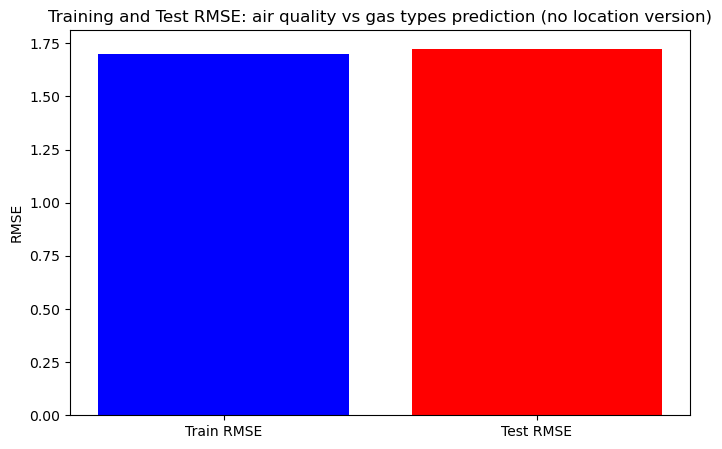

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [24]:
y_train_pred_county_year =  model_with_counties_and_gas_types.predict(x_train)
y_test_pred_county_year =  model_with_counties_and_gas_types.predict(x_test)

rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred_county_year))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred_county_year))

plt.figure(figsize=(8, 5))
plt.bar(['Train RMSE', 'Test RMSE'], [rmse_train, rmse_test], color=['blue', 'red'])
plt.ylabel('RMSE')
plt.title('Training and Test RMSE: air quality vs gas types prediction (no location version)')
plt.show()
plt.savefig("rmse_quality_vs_gas_county_predictions.png")

plt.figure()